In [ ]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install matplotlib

In [145]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [146]:
# Load the image from TestImages folder and display it
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [147]:
def filter_image(image):
    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color ranges for white, yellow and gray in HSV
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 255, 255])
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    lower_gray = np.array([0, 0, 0])
    upper_gray = np.array([180, 255, 100])  # You can adjust the upper limit based on how dark you want to consider as gray

    # Create masks for white, yellow and gray in HSV
    mask_white_hsv = cv2.inRange(hsv, lower_white, upper_white)
    mask_yellow_hsv = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask_gray_hsv = cv2.inRange(hsv, lower_gray, upper_gray)

    # Define color ranges for white, yellow and gray in RGB
    lower_white = np.array([200, 200, 200])
    upper_white = np.array([255, 255, 255])
    lower_yellow = np.array([150, 150, 0])
    upper_yellow = np.array([255, 255, 100])
    lower_gray = np.array([100, 100, 100])  # You can adjust the lower limit based on how light you want to consider as gray
    upper_gray = np.array([200, 200, 200])  # You can adjust the upper limit based on how dark you want to consider as gray

    # Create masks for white, yellow and gray in RGB
    mask_white_rgb = cv2.inRange(image, lower_white, upper_white)
    mask_yellow_rgb = cv2.inRange(image, lower_yellow, upper_yellow)
    mask_gray_rgb = cv2.inRange(image, lower_gray, upper_gray)

    # Combine the masks
    mask_hsv = cv2.bitwise_or(mask_white_hsv, mask_yellow_hsv, mask_gray_hsv)
    mask_rgb = cv2.bitwise_or(mask_white_rgb, mask_yellow_rgb, mask_gray_rgb)
    mask = cv2.bitwise_or(mask_hsv, mask_rgb)

    # Apply the mask to the image
    filtered_image = cv2.bitwise_and(image, image, mask=mask)

    return filtered_image

In [148]:
# Apply Gray Scale and display the image
def apply_gray_scale(filtered_image):
    gray_image = cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY)
    return gray_image

In [149]:
# Apply Gaussian Blur and display the image
def apply_gaussian_blur(gray_image):
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    return blurred_image

In [150]:
# Apply Canny Edge Detection and display the image
def apply_canny_edge_detection(blurred_image):
    edges = cv2.Canny(blurred_image, 50, 150)
    return edges

In [177]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # Define a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Define a four sided polygon (trapezoid) to mask
    imshape = img.shape
    vertices = np.array([[(0, imshape[0]), (imshape[1]*0.1, imshape[0]*0.4), (imshape[1]*0.9, imshape[0]*0.4), (imshape[1], imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [189]:
# Apply Hough Line Transform and display the image
def hough_lines(image):
    """
    Determine the lines in the image using Hough Transform
    Parameters:
            image: we pass here the output from canny where we have
            identified edges in the frame
    """
    lines = cv2.HoughLinesP(
        image, cv2.HOUGH_PROBABILISTIC, np.pi / 180, 85, minLineLength=20, maxLineGap=100
    )

    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    if lines is None:
        return line_image
    for x in range(0, len(lines)):
        for x1, y1, x2, y2 in lines[x]:
            # cv2.line(inputImage,(x1,y1),(x2,y2),(0,128,0),2, cv2.LINE_AA)
            pts = np.array([[x1, y1], [x2, y2]], np.int32)
            cv2.polylines(line_image, [pts], True, (0, 255, 0))

    return line_image

In [190]:
# Find Contours and display the image
def find_contours(image, hough_image):

    hough_gray_image = cv2.cvtColor(hough_image, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(
        hough_gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contours_image = image.copy()
    cv2.drawContours(contours_image, contours, -1, (0, 255, 0), 2)
    return contours_image

In [191]:
# Plot all images max 3 in a row with labels using loop
def plot_images(images, titles, rows, cols):
    """
    Plot multiple images in a row with titles
    Parameters:
            images: list of images to plot
            titles: list of titles to give to each image
            rows: number of rows in the plot
            cols: number of columns in the plot
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i])
            ax.axis("off")
    plt.tight_layout()
    plt.show()

In [192]:
def find_image_lane(image_path):
    image = load_image(image_path)
    filtered_image = filter_image(image)
    gray_image = apply_gray_scale(filtered_image)
    blurred_image = apply_gaussian_blur(gray_image)
    edges = apply_canny_edge_detection(blurred_image)
    roi_image = region_of_interest(edges)
    hough_image = hough_lines(roi_image)
    contours_image = find_contours(image, hough_image)
    
    # Plot all images
    images = [image, filtered_image, gray_image, blurred_image, edges, roi_image, hough_image, contours_image]
    titles = [
        "Original Image",
        "Filtered Image",
        "Gray Image",
        "Blurred Image",
        "Edges",
        "ROI",
        "Hough Lines",
        "Contours",
    ]
    plot_images(images, titles, 4, 2)

In [193]:
def detect_image_lanes():
    images = ["image1.jpeg", "image2.jpeg", "image3.jpeg", "image4.jpg", "image5.jpg", "image6.jpg", "image7.jpg", "image8.jpg", "image9.jpg", "image10.jpg"]

    for _image in images:
        image = load_image(f"Test Images/{_image}")
        filtered_image = filter_image(image)
        gray_image = apply_gray_scale(filtered_image)
        blurred_image = apply_gaussian_blur(gray_image)
        edges = apply_canny_edge_detection(blurred_image)
        roi_image = region_of_interest(edges)
        hough_image = hough_lines(roi_image)
        contours_image = find_contours(image, hough_image)
        
        plt.imshow(contours_image, cmap='gray')
        plt.title(f"{_image}")
        plt.show()

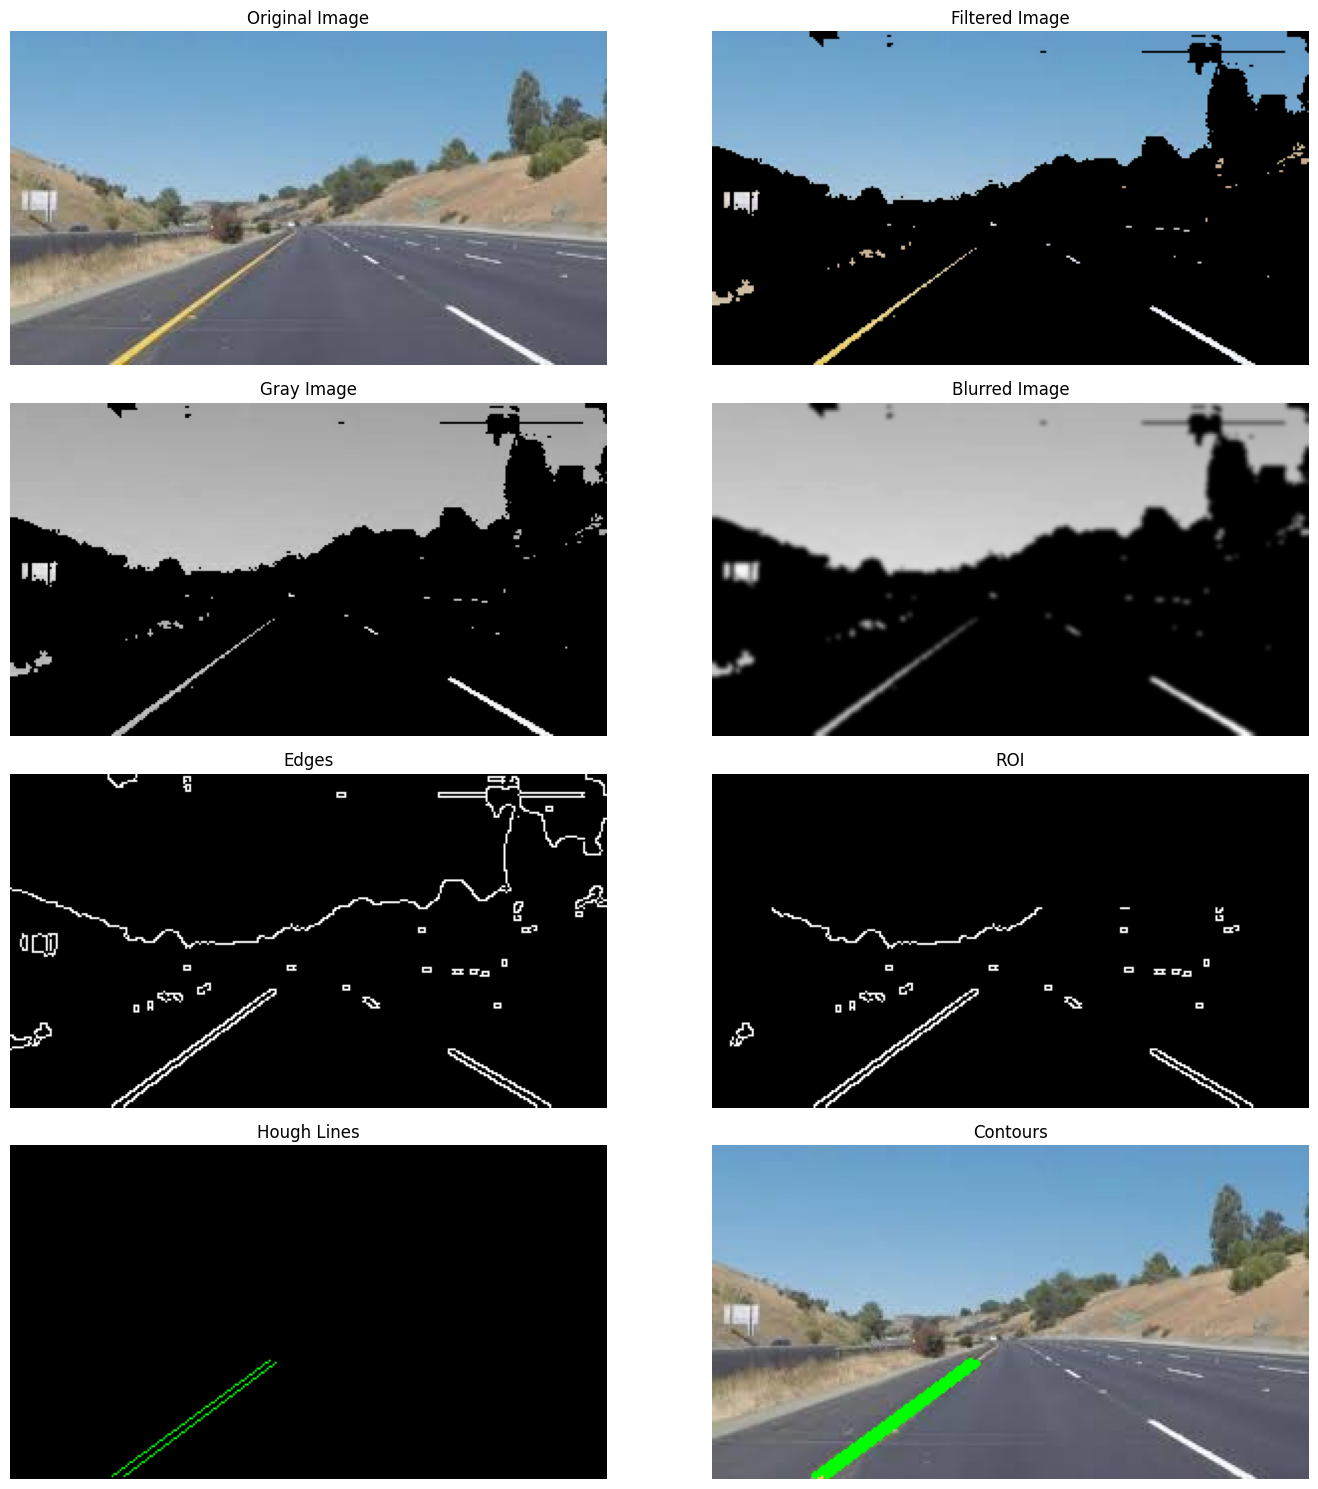

In [194]:
find_image_lane("Test Images/image3.jpeg")

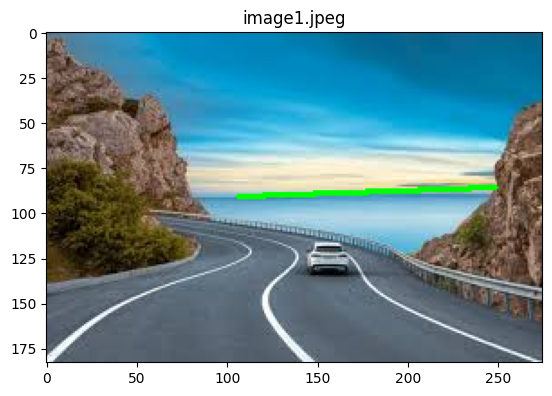

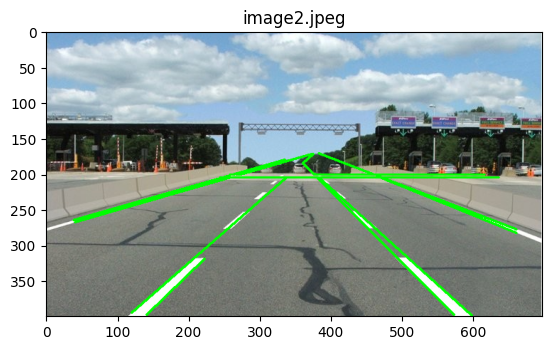

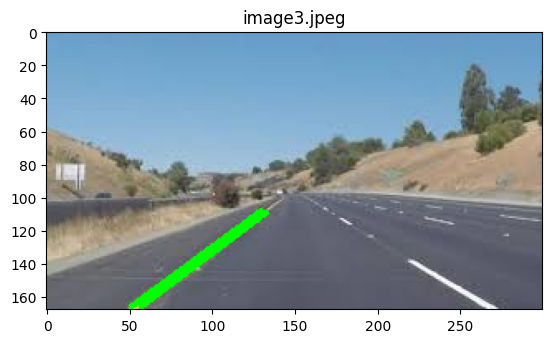

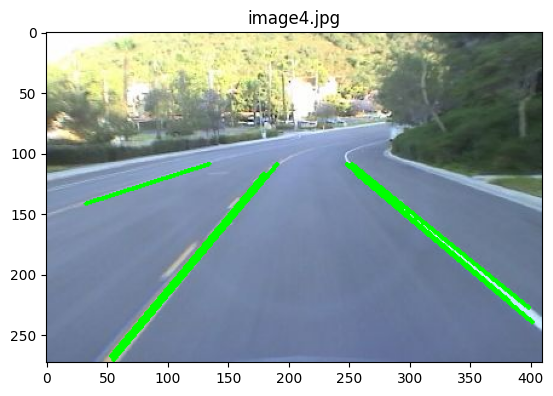

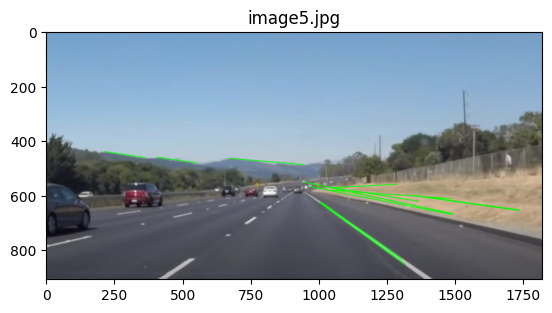

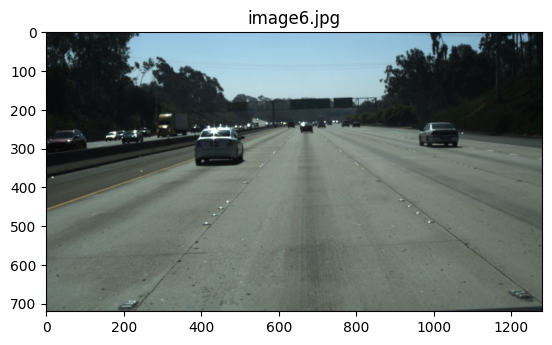

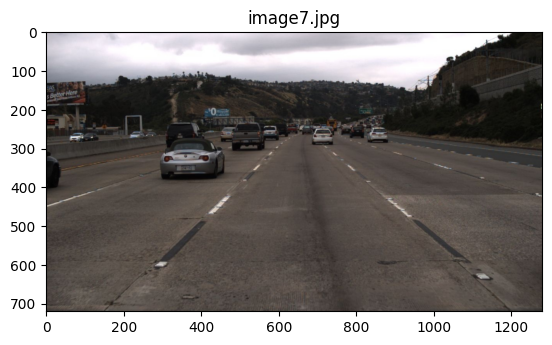

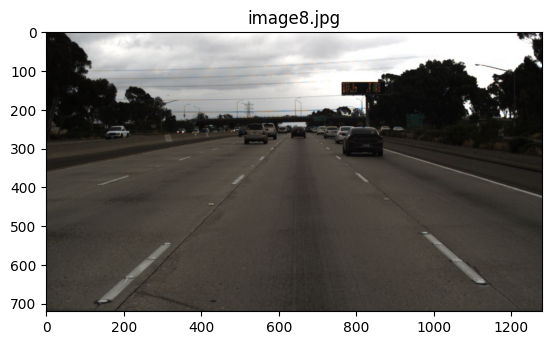

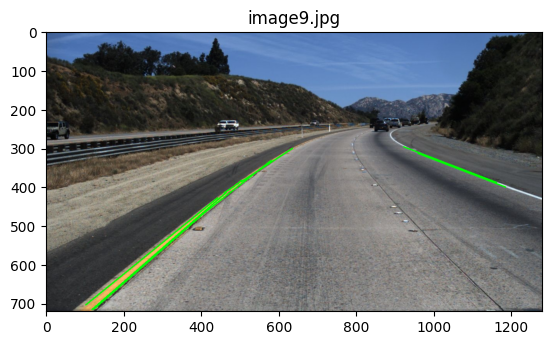

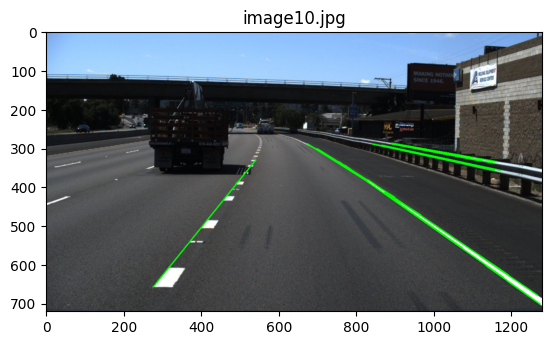

In [195]:
detect_image_lanes()